In [25]:
import numpy as np 
import pandas as pd
import open3d as o3d
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.lines as mlines
import seaborn as sns
import scipy.stats as st

from data_processing import excel_to_pcd, preprocess_point_cloud, process_images, colour_map
from align_func import execute_global_registration, icp_registration, colored_icp, calculate_mae

# Introduction

To assess the performance of the registration pipeline more stringently, we sought to compare the algorithm's performance across various datasets. The datasets we have chosen for comparison are:

1. Images of two separate zebrafish tailbuds at 18ss. We called this pair of images `Test sample`. `Test sample` exemplifies the performance of the algorithm on an actual use case as in practice, ZebReg is used to align different tailbuds of the same stage to a target image.

2. Images of two lateral halves of a single 18ss tailbud image. We called this pair of images `Lateral halves`. Since the point clouds do not overlap, any correspondence between the points in `Lateral halves` are spurious. However, given that the lateral halves of the embryo are quite symmetrical, we expect this to be a rather tricky example for the algorithm as many points may coincide in space by chance. In addition, the expression of sox2, which is the color intensity channel used in the colored ICP alignment, shows a superficially similar spatial expression distribution between the lateral halves. 

3. Images of the anterior and posterior ends of a single 18ss tailbud image. We called this pair of images `AP`. Similar to `Lateral halves`, any correspondence found between points are spurious. However, as both the gene expression distribution and the position of points differ significantly between the anterior and posterior ends of the tailbud, we expect `AP` to perform the worst amongst the three datasets.

For the metrics to be useful, we expect `Test sample` to perform the best, followed in order by `Lateral halves` and `AP`. 

Whilst we were able to rank the relative performances of the algorithm when applied on these three datasets, we have yet to measure the absolute performance of the algorithm. To quantify the algorithm's absolute performance, we generated a series of noise-corrupted versions of a source image, where for a corrupted image, stochasticity has been added to the positions of all points. Specifically, we added a zero-mean gaussian noise array such that corrupted images differ from one another with respect to the standard deviation of the gaussian noise added. 

Ultimately, the purpose of this procedure was to register each corrupted version back onto the original, uncorrupted copy. As the stochasticity increases with increasing standard deviation, we expect the performance of the algorithm to degrade on all metrics as the noise standard deviation increases. We thus recover a `noise-calibration` curve, which we can then use to evaluate the algorithm's performance on `Test sample`, `Lateral halves` and `AP`.




# Functions

In [26]:
def process_color(filepath, skiprows, usecols):
    color_excel = pd.read_excel(filepath, skiprows = skiprows, header = 0, usecols = usecols) 
    image_color = color_excel.to_numpy(dtype='float64')
    min_intensity=np.amin(image_color)
    max_intensity=np.amax(image_color)
    norm_color = (image_color - min_intensity) / (max_intensity - min_intensity) *100 
    return norm_color


In [172]:
def simulate_noise(source_pos_path, target_pos_path, source_color_path, target_color_path, 
                   sd_range = 100, sd_interval = 100, sim_num = 2, ax = None, legend = True,
                  title = None, x_label = "Noise (standard deviation)", y_label = "Metric results",
                  results_only = False):
    
    source_color = process_color(source_color_path, [0,1,2], [0])
    target_color = process_color(target_color_path, [0,1,2], [0])
    
    positions_paths = [source_pos_path] + [target_pos_path]
    color_paths = [source_color_path] + [target_color_path]

    pcd,fpfh,image_rgb = process_images(positions_paths, color_paths, skiprows = [0,1,2])
    source, target = pcd
    source_fpfh,target_fpfh = fpfh
    source_rgb, target_rgb = image_rgb
    
    """ Noise simulation"""
    noise_sd = np.linspace(0,sd_range,sd_interval)
    len_noise = len(noise_sd)
    size_data = np.asarray(source.points).shape
    
    list_of_arrays = [np.asarray(source.points) for i in range(len_noise)]
    results_list = []

    for j in range(sim_num):
        np.random.seed(j)
        print(f"----------Simulation num: {j+1}----------")
        for i in range(len_noise):
            noise = np.random.normal(0,noise_sd[i],size_data)
            noise_add2_data = list_of_arrays[i] + noise

            noise_pcd=o3d.geometry.PointCloud() #Creating the PointCloud object constructor 
            noise_pcd.points=o3d.utility.Vector3dVector(np.asarray(noise_add2_data))

            result_ransac_rotate = execute_global_registration(noise_pcd, target,
                                                    source_fpfh, target_fpfh)

            result_colored_icp = colored_icp(noise_pcd, target, result_ransac_rotate.transformation, voxel_radius = 10, coloredICP_maxnn = 50, downsample = False)
            mae_regis = calculate_mae(source_rgb, target_rgb, result_colored_icp)
            results_list.append([result_colored_icp.fitness, result_colored_icp.inlier_rmse, (result_colored_icp.inlier_rmse)/(result_colored_icp.fitness), mae_regis, np.asarray(result_colored_icp.correspondence_set).shape[0]])
            
            
    result_array = np.array(results_list)
    result = np.reshape(result_array, (sim_num,sd_interval,5))
    result_mean = np.mean(result, axis = 0)
    
    fitness = [mylist[0] for mylist in result_mean]
    inlier_rmse = [mylist[1] for mylist in result_mean]
    scaled_inlier_rmse = [mylist[2] for mylist in result_mean]
    mae = [mylist[3] for mylist in result_mean]
    corr_num = [mylist[4] for mylist in result_mean]

    
    if results_only:
        return np.asarray([fitness, inlier_rmse, scaled_inlier_rmse, mae,corr_num])
    
    else:
        """ Plotting"""

        if ax is None:
            ax = plt.gca()
        ax.plot(noise_sd, fitness, label='Fitness')
        ax.plot(noise_sd, inlier_rmse, label='Inlier RMSE')
        ax.plot(noise_sd, mae, label='MAE')

        if legend:
            ax.legend(loc = "upper left")

        if title:
            ax.set_title(label = title)

        if x_label:
            ax.set_xlabel(x_label)

        if y_label:
            ax.set_ylabel(y_label)

        return ax

    

    

# Specifying file paths

In [28]:
""" Mapping to self """
target_self = "./datasets/2-permutation/xyz_target.xls"
dup_self = "./datasets/2-permutation/xyz_target.xls"
target_color_self = "./datasets/2-permutation/sox2_target.xls"
dup_color_self = "./datasets/2-permutation/sox2_target.xls"

In [29]:
""" Mapping to test sample"""
target_test = "./datasets/2-permutation/xyz_target.xls"
source_test = "./datasets/2-permutation/xyz_source.xls"
target_color_test = "./datasets/2-permutation/sox2_target.xls"
source_color_test = "./datasets/2-permutation/sox2_source.xls"


In [30]:
""" Mapping to mutually exclusive domains - filter by z"""
target_z = "./datasets/3-noise/pos_lateral_front.xls"
source_z = "./datasets/3-noise/pos_lateral_back.xls"
target_color_z = "./datasets/3-noise/sox2_lateral_front.xls"
source_color_z = "./datasets/3-noise/sox2_lateral_back.xls"

In [31]:
""" Mapping to mutually exclusive domains - filter by x"""
target_x = "./datasets/3-noise/pos_anterior_half.xls"
source_x= "./datasets/3-noise/pos_posterior_half.xls"
target_color_x = "./datasets/3-noise/sox2_anterior_half.xls"
source_color_x = "./datasets/3-noise/sox2_posterior_half.xls"

# Plotting (skip this as curve trends are not useful for interpretation)

:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
----------Simulation num: 1----------
----------Simulation num: 2----------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
----------Simulation num: 1----------
----------Simulation num: 2----------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downs

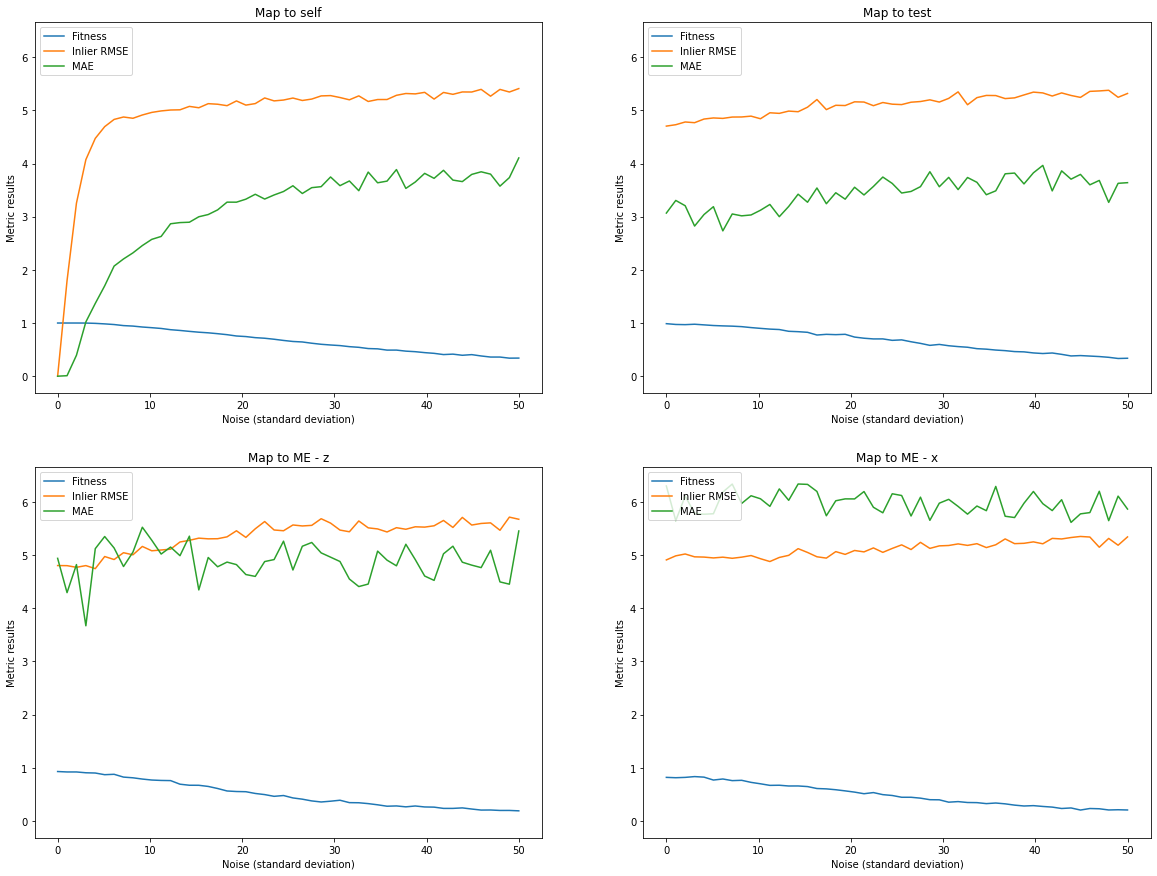

In [187]:
fig = plt.figure(figsize=(20,15))

ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222, sharex = ax0, sharey = ax0)
ax2 = fig.add_subplot(223, sharex = ax0, sharey = ax0)
ax3 = fig.add_subplot(224, sharex = ax0, sharey = ax0)

simulate_noise(dup_self, target_self, dup_color_self, target_color_self, sd_range = 50, sd_interval = 50, ax = ax0, title = "Map to self")
simulate_noise(source_test, target_test, source_color_test, target_color_test, sd_range = 50, sd_interval = 50, ax = ax1, title = "Map to test")
simulate_noise(source_z, target_z, source_color_z, target_color_z, sd_range = 50, sd_interval = 50, ax = ax2, title = "Map to ME - z")
simulate_noise(source_x, target_x, source_color_x, target_color_x, sd_range = 50, sd_interval = 50, ax = ax3, title = "Map to ME - x")


# Calibration curve approach

In [173]:
def regis_results(source_pos_path, target_pos_path, source_color_path, target_color_path):
    results_list = []
    source_color = process_color(source_color_path, [0,1,2], [0])
    target_color = process_color(target_color_path, [0,1,2], [0])
    
    positions_paths = [source_pos_path] + [target_pos_path]
    color_paths = [source_color_path] + [target_color_path]

    pcd,fpfh,image_rgb = process_images(positions_paths, color_paths, skiprows = [0,1,2])
    source, target = pcd
    source_fpfh,target_fpfh = fpfh
    source_rgb, target_rgb = image_rgb
    
    
    result_ransac_rotate = execute_global_registration(source, target,
                                            source_fpfh, target_fpfh)

    result_colored_icp = colored_icp(source, target, result_ransac_rotate.transformation, voxel_radius = 10, coloredICP_maxnn = 50, downsample = False)
    mae_regis = calculate_mae(source_rgb, target_rgb, result_colored_icp)
    results_list.append([result_colored_icp.fitness, result_colored_icp.inlier_rmse,  (result_colored_icp.inlier_rmse)/(result_colored_icp.fitness), mae_regis, np.asarray(result_colored_icp.correspondence_set).shape[0]])
    
    return np.asarray(results_list).flatten()
    

In [175]:
self_results = regis_results(dup_self, target_self, dup_color_self, target_color_self)
test_results = regis_results(source_test, target_test, source_color_test, target_color_test)
me_z = regis_results(source_z, target_z, source_color_z, target_color_z)
me_x = regis_results(source_x, target_x, source_color_x, target_color_x)


:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud w

In [176]:
sd_range = 50
x = np.linspace(0, sd_range, 50)
y = simulate_noise(dup_self, target_self, dup_color_self, target_color_self, sd_range = sd_range, sd_interval = 50, results_only = True)

:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
---------------------------------------
----------Simulation num: 1----------
----------Simulation num: 2----------


## Fitness- Calibration Curve

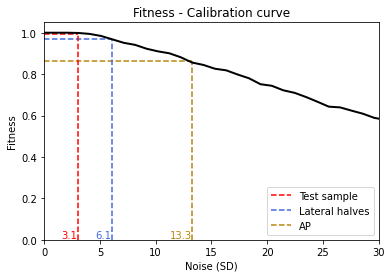

In [177]:
plt.plot(x,y[0], linewidth = 2, color = "black")
plt.title("Fitness - Calibration curve")
plt.xlabel("Noise (SD)")
plt.ylabel("Fitness")

noise_test = np.isclose(y[0], test_results[0], atol = 0.005)
noise_me_z= np.isclose(y[0], me_z[0], atol = 0.01)
noise_me_x = np.isclose(y[0], me_x[0], atol = 0.01)

plt.hlines(y=test_results[0], xmin=0, xmax=x[noise_test][0], linestyles = "dashed", color = "red")
plt.hlines(y=me_z[0], xmin=0, xmax=x[noise_me_z][0], linestyles = "dashed", color = "royalblue")
plt.hlines(y=me_x[0], xmin=0, xmax=x[noise_me_x][0], linestyles = "dashed", color = "darkgoldenrod")

plt.vlines(x=x[noise_test][0], ymin=0, ymax=test_results[0], linestyles = "dashed", color = "red")
plt.vlines(x=x[noise_me_z][0], ymin=0, ymax=me_z[0], linestyles = "dashed", color = "royalblue")
plt.vlines(x=x[noise_me_x][0], ymin=0, ymax=me_x[0], linestyles = "dashed", color = "darkgoldenrod")

plt.xlim([0,30])
plt.ylim([0,1.05])

line_red = mlines.Line2D([], [], color='red',label='Test sample', linestyle =  '--')
line_blue = mlines.Line2D([], [], color='royalblue',label='Lateral halves', linestyle =  '--')
line_gold = mlines.Line2D([], [], color='darkgoldenrod',label='AP', linestyle =  '--')

plt.annotate(xy=[x[noise_test][0]-1.5, 0.01], s=x[noise_test][0].round(1), color = "red")
plt.annotate(xy=[x[noise_me_z][0]-1.5, 0.01], s=x[noise_me_z][0].round(1), color = "royalblue")
plt.annotate(xy=[x[noise_me_x][0]-2, 0.01], s=x[noise_me_x][0].round(1), color = "darkgoldenrod")


plt.legend(handles=[line_red, line_blue, line_gold], loc = "lower right") 

#plt.savefig('Fitness-Calibration_Curve.png')

## Inlier RMSE - Calibration Curve

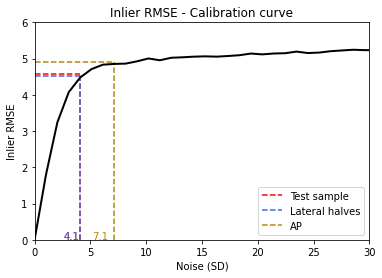

In [178]:
plt.plot(x,y[1], linewidth = 2, color = "black")
plt.title("Inlier RMSE - Calibration curve")
plt.xlabel("Noise (SD)")
plt.ylabel("Inlier RMSE")

noise_test = np.isclose(y[1], test_results[1], atol = 0.15)
noise_me_z= np.isclose(y[1], me_z[1], atol = 0.15)
noise_me_x = np.isclose(y[1], me_x[1], atol = 0.05)


plt.hlines(y=test_results[1], xmin=0, xmax=x[noise_test][0], linestyles = "dashed", color = "red")
plt.hlines(y=me_z[1], xmin=0, xmax=x[noise_me_z][0], linestyles = "dashed", color = "royalblue")
plt.hlines(y=me_x[1], xmin=0, xmax=x[noise_me_x][0], linestyles = "dashed", color = "darkgoldenrod")

plt.vlines(x=x[noise_test][0], ymin=0, ymax=test_results[1], linestyles = "dashed", color = "red")
plt.vlines(x=x[noise_me_z][0], ymin=0, ymax=me_z[1], linestyles = "dashed", color = "royalblue")
plt.vlines(x=x[noise_me_x][0], ymin=0, ymax=me_x[1], linestyles = "dashed", color = "darkgoldenrod")

plt.xlim([0,30])
plt.ylim([0,6])

line_red = mlines.Line2D([], [], color='red',label='Test sample', linestyle =  '--')
line_blue = mlines.Line2D([], [], color='royalblue',label='Lateral halves', linestyle =  '--')
line_gold = mlines.Line2D([], [], color='darkgoldenrod',label='AP', linestyle =  '--')

plt.annotate(xy=[x[noise_test][0]-1.5, 0.01], s=x[noise_test][0].round(1), color = "red")
plt.annotate(xy=[x[noise_me_z][0]-1.5, 0.01], s=x[noise_me_z][0].round(1), color = "royalblue")
plt.annotate(xy=[x[noise_me_x][0]-2, 0.01], s=x[noise_me_x][0].round(1), color = "darkgoldenrod")


plt.legend(handles=[line_red, line_blue, line_gold], loc = "lower right") 
#plt.savefig('Inlier_RMSE-Calibration_Curve.png')

# Scaled inlier RMSE - Calibration curve

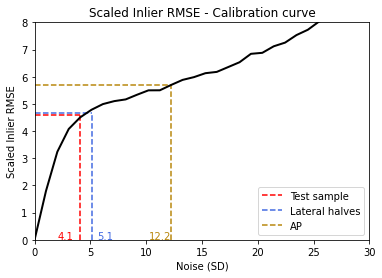

In [185]:
plt.plot(x,y[2], linewidth = 2, color = "black")
plt.title("Scaled Inlier RMSE - Calibration curve")
plt.xlabel("Noise (SD)")
plt.ylabel("Scaled Inlier RMSE")

noise_test = np.isclose(y[2], test_results[2], atol = 0.15)
noise_me_z= np.isclose(y[2], me_z[2], atol = 0.15)
noise_me_x = np.isclose(y[2], me_x[2], atol = 0.15)


plt.hlines(y=test_results[2], xmin=0, xmax=x[noise_test][0], linestyles = "dashed", color = "red")
plt.hlines(y=me_z[2], xmin=0, xmax=x[noise_me_z][0], linestyles = "dashed", color = "royalblue")
plt.hlines(y=me_x[2], xmin=0, xmax=x[noise_me_x][0], linestyles = "dashed", color = "darkgoldenrod")

plt.vlines(x=x[noise_test][0], ymin=0, ymax=test_results[2], linestyles = "dashed", color = "red")
plt.vlines(x=x[noise_me_z][0], ymin=0, ymax=me_z[2], linestyles = "dashed", color = "royalblue")
plt.vlines(x=x[noise_me_x][0], ymin=0, ymax=me_x[2], linestyles = "dashed", color = "darkgoldenrod")

plt.xlim([0,30])
plt.ylim([0,8])

line_red = mlines.Line2D([], [], color='red',label='Test sample', linestyle =  '--')
line_blue = mlines.Line2D([], [], color='royalblue',label='Lateral halves', linestyle =  '--')
line_gold = mlines.Line2D([], [], color='darkgoldenrod',label='AP', linestyle =  '--')

plt.annotate(xy=[x[noise_test][0]-2, 0.01], s=x[noise_test][0].round(1), color = "red")
plt.annotate(xy=[x[noise_me_z][0]+0.5, 0.01], s=x[noise_me_z][0].round(1), color = "royalblue")
plt.annotate(xy=[x[noise_me_x][0]-2, 0.01], s=x[noise_me_x][0].round(1), color = "darkgoldenrod")


plt.legend(handles=[line_red, line_blue, line_gold], loc = "lower right") 
#plt.savefig('Inlier_RMSE-Calibration_Curve.png')

## MAE - Calibration Curve

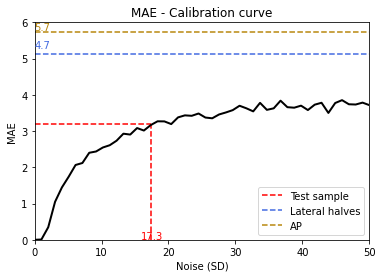

In [181]:
plt.plot(x,y[3], linewidth = 2, color = "black")
plt.title("MAE - Calibration curve")
plt.xlabel("Noise (SD)")
plt.ylabel("MAE")

noise_test = np.isclose(y[3], test_results[3], atol = 0.05)
#noise_me_z= np.isclose(y[2], me_z[2], atol = 1.8)
#noise_me_x = np.isclose(y[2], me_x[2], atol = 1.8)

plt.hlines(y=test_results[3], xmin=0, xmax=x[noise_test][0], linestyles = "dashed", color = "red")
plt.hlines(y=me_z[3], xmin=0, xmax=60, linestyles = "dashed", color = "royalblue")
plt.hlines(y=me_x[3], xmin=0, xmax=60, linestyles = "dashed", color = "darkgoldenrod")

plt.vlines(x=x[noise_test][0], ymin=0, ymax=test_results[3], linestyles = "dashed", color = "red")
#plt.vlines(x=x[noise_me_z][0], ymin=0, ymax=me_z[2], linestyles = "dashed", color = "royalblue")
#plt.vlines(x=x[noise_me_x][0], ymin=0, ymax=me_x[2], linestyles = "dashed", color = "darkgoldenrod")

plt.xlim([0,50])
plt.ylim([0,6])

line_red = mlines.Line2D([], [], color='red',label='Test sample', linestyle =  '--')
line_blue = mlines.Line2D([], [], color='royalblue',label='Lateral halves', linestyle =  '--')
line_gold = mlines.Line2D([], [], color='darkgoldenrod',label='AP', linestyle =  '--')

plt.annotate(xy=[x[noise_test][0]-1.5, 0.01], s=x[noise_test][0].round(1), color = "red")
plt.annotate(xy=[0, 5.3], s=me_z[2].round(1), color = "royalblue")
plt.annotate(xy=[0, 5.772], s=me_x[2].round(1), color = "darkgoldenrod")


plt.legend(handles=[line_red, line_blue, line_gold], loc = "lower right") 
#plt.savefig('MAE-Calibration_Curve.png')

## Correspondence set size 

Text(0, 0.5, 'Correspondence set size')

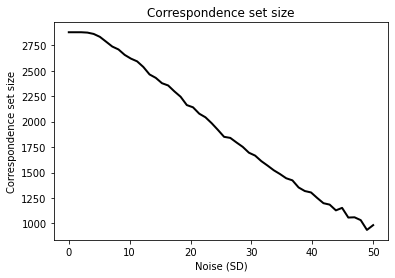

In [191]:
plt.plot(x,y[4], linewidth = 2, color = "black")
plt.title("Correspondence set size")
plt.xlabel("Noise (SD)")
plt.ylabel("Correspondence set size")

#plt.savefig('1c)corr_set_size-.png')


In [190]:
print(f"Is fitness calculated as correspondence set size / number of source points? {test_results[4]/2363 == test_results[0]}")

Is fitness calculated as correspondence set size / number of source points? True


# Figure caption:

Noise calibration curves for the (a) Fitness (b) Scaled Inlier RMSE (c) MAE metrics. A calibration curve was constructed for each metric by registering a zero-mean, Gaussian noise-corrupted image to its original, uncorrupted copy and performing successive image registrations with noise of varying standard deviations (SD). For all three metrics, the calibration curves show that `Test sample` (red) registration performs better than the `Lateral halves`(blue) registration, which in turn performs better than the `AP`(gold) registration. (Scaled Inlier RMSE was calculated as inlier RMSE / fitness to account for the different number of inlier points.)


# Result analysis

From our analysis, we observe that for the `fitness metric`, the `Test sample` registration result is comparable to registering an image to a 3.1 SD, noise-corrupted version of itself. 
